In [7]:
import copy
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import torch,torchvision
from torch import nn,save,load       #neural network module
from torch.optim import Adam      #optimizer used
from torch.utils.data import DataLoader     #load a dataset
from torchvision import datasets         
from torchvision.transforms import ToTensor       #to convert to tensor
from sklearn import metrics

In [9]:
T=torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_data=torchvision.datasets.MNIST('mnist_data',train=True,download=True,transform=T)  #transforming to tensor
val_data=torchvision.datasets.MNIST('mnist_data',train=False,download=True,transform=T)
print(len(val_data))
test_set,val_set=torch.utils.data.random_split(val_data,[5000,5000])

train_dl=torch.utils.data.DataLoader(train_data,64)     #batch size =64
val_dl=torch.utils.data.DataLoader(val_set,64)     
test_dl=torch.utils.data.DataLoader(test_set,64)  

10000


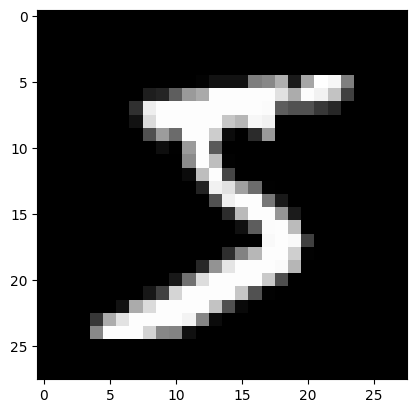

In [11]:
plt.imshow(train_data[0][0][0],cmap="gray")

In [13]:
class MNIST(nn.Module):
    
    def __init__(self):
        super(MNIST,self).__init__()
        self.model=nn.Sequential(
        nn.Conv2d(1,6,5,padding=2),     #input,output,filter dimensions the padding and stride
        nn.ReLU(),
        nn.AvgPool2d(2,stride=2),
        
        nn.Conv2d(6,16,5,padding=0),
        nn.ReLU(),
        nn.AvgPool2d(2,stride=2),
        
        nn.Flatten(),
        nn.Linear(400,120),           #16*5*5
        nn.Linear(120,84),
        nn.Linear(84,10)   #total no.of digits=10
        )
    
    
    def forward(self,out):
        x=self.model(out)
        return x

In [15]:
#accuracy of the model

def validate(model,data):
    total=0
    correct=0
    for i,(images,labels) in enumerate(data):
        x=model(images)
        value,pred=torch.max(x,1)
        total=total+x.size(0)
        correct=correct+torch.sum(pred==labels)
    return correct/total *100    

In [17]:
def train(epochs):
    
    accuracies=[]
    max=0
    cnn=MNIST().to('cpu')
    loss=nn.CrossEntropyLoss()
    opt=Adam(cnn.parameters(),lr=0.001)
    
    for epoch in range(epochs):
        for i,(images,labels) in enumerate(train_dl):
            images=images.to('cpu')
            labels=labels.to('cpu')
            
            opt.zero_grad()        #initialising to zero
            pred=cnn(images)
            l=loss(pred,labels)
            l.backward()        #backpropagation
            opt.step()             #gradient descent
        accuracy=float(validate(cnn,val_dl))  
        accuracies.append(accuracy)
        if(accuracy>max):
            best_model=copy.deepcopy(cnn)
            max=accuracy
            print("Till now best accuracy: ",accuracy)
        plt.plot(accuracies)    
        print("Epoch:",epoch+1, "Accuracy: ",accuracy)
        
    return best_model

Till now best accuracy:  97.25999450683594
Epoch: 1 Accuracy:  97.25999450683594
Till now best accuracy:  98.27999877929688
Epoch: 2 Accuracy:  98.27999877929688
Till now best accuracy:  98.72000122070312
Epoch: 3 Accuracy:  98.72000122070312
Till now best accuracy:  98.86000061035156
Epoch: 4 Accuracy:  98.86000061035156
Till now best accuracy:  99.0199966430664
Epoch: 5 Accuracy:  99.0199966430664


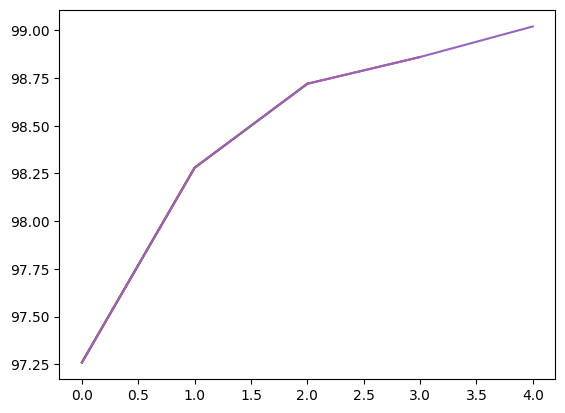

In [18]:
M=train(5)

In [19]:
#predicting the testing set

def predict(model,data):
    y_pred=[]
    y_true=[]
    for i,(images,labels) in enumerate(data):
        x=model(images)
        value,pred=torch.max(x,1)
        y_pred.extend(list(pred.numpy()))
        y_true.extend(list(labels.numpy()))
    return np.array(y_pred),np.array(y_true)

In [20]:
y_pred,y_true=predict(M,test_dl)

In [21]:
#confusion matrix

x=metrics.confusion_matrix(y_true,y_pred,labels=np.arange(0,10))
x

array([[477,   0,   0,   0,   0,   0,   0,   1,   1,   0],
       [  0, 584,   1,   0,   0,   0,   0,   0,   0,   0],
       [  0,   3, 502,   0,   0,   0,   0,   1,   3,   0],
       [  0,   0,   1, 519,   0,   2,   0,   1,   0,   0],
       [  0,   0,   2,   0, 463,   0,   2,   1,   0,   2],
       [  1,   0,   0,   1,   0, 436,   1,   0,   0,   0],
       [  3,   3,   0,   0,   0,   8, 472,   0,   2,   0],
       [  0,   1,   6,   0,   0,   0,   0, 493,   0,   0],
       [  2,   0,   2,   2,   0,   0,   0,   0, 492,   0],
       [  1,   3,   0,   1,   7,   0,   0,   3,   2, 492]], dtype=int64)

In [22]:
#saving parameters
model=MNIST()
torch.save(M.state_dict(),'model1.pt')

print(M.state_dict())

OrderedDict([('model.0.weight', tensor([[[[ 0.0423, -0.2702, -0.1532,  0.1341,  0.0493],
          [-0.1601, -0.0023, -0.1988, -0.0975,  0.3141],
          [-0.0900, -0.3107, -0.1026,  0.3001,  0.2562],
          [-0.0979, -0.2414,  0.1621, -0.0155,  0.3189],
          [-0.1580,  0.0738,  0.0400,  0.3564,  0.1151]]],


        [[[ 0.2475,  0.0701, -0.0313,  0.0278,  0.1600],
          [-0.0346, -0.3315, -0.3057, -0.0867,  0.2101],
          [-0.2803,  0.0276,  0.0148,  0.0471,  0.1765],
          [-0.1068, -0.2539, -0.2333,  0.1156, -0.1493],
          [-0.2933, -0.0851,  0.0473, -0.1193, -0.0969]]],


        [[[-0.1464,  0.1049,  0.0508, -0.0935, -0.0643],
          [ 0.0304, -0.2006, -0.3493, -0.0844, -0.2939],
          [-0.0870, -0.1891, -0.0080, -0.1919,  0.0754],
          [ 0.3152,  0.2681, -0.0487,  0.2804,  0.1612],
          [ 0.2323,  0.0867,  0.2603,  0.1547,  0.1454]]],


        [[[-0.1297,  0.2381,  0.1894,  0.1677, -0.1066],
          [-0.2719,  0.1083, -0.0613,  0.133